# Model Building on Timeseries indices

## Model Training

In [9]:
# Import packages 
import os 
import numpy as np
import pandas as pd
import xarray as xr
os.chdir('/Users/kaushalk/Desktop/open_projects/Telengana_Crop_Health/')
# Add the 'src' directory to the Python path
from src.process_data import compute_indices_for_df, prepare_model_data
from src.visualize import plot_numerical_distributions, plot_confusion_matrix

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, f1_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [1132]:
import pandas as pd
import numpy as np

import pandas as pd

def prepare_training_data(qtr_file: str, indices_file: str, target_substrings=None, columns_to_drop=None):
    """
    Prepare the final dataset for model training and testing.

    Parameters:
    - qtr_file (str): Path to the quarter index file (e.g., 'train_qtr_indx.csv').
    - indices_file (str): Path to the indices file (e.g., 'training_s2_indices_v1.csv').
    - target_substrings (list): List of substrings to identify columns for mean calculation.
    - columns_to_drop (list): List of columns to drop from the final dataset.

    Returns:
    - pd.DataFrame: Preprocessed DataFrame ready for model training.
    """
    # Default parameters
    if target_substrings is None:
        target_substrings = ['M3', 'M4', 'M5', 'M6', 'M7', 'M8']
    if columns_to_drop is None:
        columns_to_drop = ['FarmID', 'State', 'District', 'Sub-District', 
                           'SDate', 'HDate', 'geometry', 'tif_path', 
                           'NDVI', 'SAVI', 'MSAVI']

    # Load data
    qdf = pd.read_csv(qtr_file, index_col=0)
    idf = pd.read_csv(indices_file, index_col=0)

    # Merge data on 'FarmID'
    df = pd.merge(idf, qdf, on="FarmID", how="inner", suffixes=('', '_drop'))
    df = df.loc[:, ~df.columns.str.endswith('_drop')]  # Drop duplicate columns

    # Calculate mean for columns matching the target substrings
    column_suffixes = {col.split('_', 1)[1] for col in df.columns if any(sub in col for sub in target_substrings)}
    for suffix in column_suffixes:
        matching_columns = [col for col in df.columns if suffix in col and any(sub in col for sub in target_substrings)]
        df[f"M_ALL_{suffix}"] = df[matching_columns].mean(axis=1)

    # Drop columns from M4 to M8 after mean calculation
    df = df.drop(columns=[col for col in df.columns if any(sub in col for sub in target_substrings)])

    # Preprocess date columns and compute time difference
    df['SDate'] = pd.to_datetime(df['SDate'])
    df['HDate'] = pd.to_datetime(df['HDate'])
    df['TDays'] = (df['HDate'] - df['SDate']).dt.days

    # Drop unnecessary columns
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Drop columns containing "M_ALL"
    df = df.iloc[:, ~df.columns.str.contains("M_ALL")]
    df = df.iloc[:, ~df.columns.str.contains("M2_")]

    # Prepare final dataset
    train_df = prepare_model_data(df)

    return train_df


def prepare_indeces_data_stats(qtr_file: str, indices_file: str, target_substrings=None, columns_to_drop=None):
    """
    Prepare the final dataset for model training and testing with enhanced statistical features.

    Parameters:
    - qtr_file (str): Path to the quarter index file (e.g., 'train_qtr_indx.csv').
    - indices_file (str): Path to the indices file (e.g., 'training_s2_indices_v1.csv').
    - target_substrings (list): List of substrings to identify columns for statistical calculations.
    - columns_to_drop (list): List of columns to drop from the final dataset.

    Returns:
    - pd.DataFrame: Preprocessed DataFrame ready for model training.
    """
    # Default parameters
    if target_substrings is None:
        target_substrings = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']
    if columns_to_drop is None:
        columns_to_drop = ['FarmID', 'State', 'District', 'Sub-District', 
                           'SDate', 'HDate', 'geometry', 'tif_path',]
                           #'NDVI', 'GNDVI', 'SAVI', 'MSAVI', 'LSWI', 'LCI']

    # Load data
    qdf = pd.read_csv(qtr_file, index_col=0)
    idf = pd.read_csv(indices_file, index_col=0)

    # Merge data on 'FarmID'
    df = pd.merge(idf, qdf, on="FarmID", how="inner", suffixes=('', '_drop'))
    df = df.loc[:, ~df.columns.str.endswith('_drop')]  # Drop duplicate columns
    # Preprocess date columns and compute time difference
    df['SDate'] = pd.to_datetime(df['SDate'])
    df['HDate'] = pd.to_datetime(df['HDate'])
    df['TDays'] = (df['HDate'] - df['SDate']).dt.days
    # Drop unnecessary columns
    df = df.drop(columns=columns_to_drop, errors='ignore')
    # Compute statistical features for M1 to M8 columns
    stats_features = ['mean', 'std']
    for stat in stats_features:
        for suffix in {col.split('_', 1)[1] for col in df.columns if any(sub in col for sub in target_substrings)}:
            matching_columns = [col for col in df.columns if suffix in col and any(sub in col for sub in target_substrings)]
            if stat == 'mean':
                df[f"M_{suffix}_mean"] = df[matching_columns].mean(axis=1)
            elif stat == 'std':
                df[f"M_{suffix}_std"] = df[matching_columns].std(axis=1)
            elif stat == 'iqr':
                # Compute IQR for matching columns
                q1 = df[matching_columns].quantile(0.25, axis=1)
                q3 = df[matching_columns].quantile(0.75, axis=1)
                df[f"M_{suffix}_iqr"] = q3 - q1
            
    #Drop M1 to M8 columns after feature extraction
    #df = df.drop(columns=[col for col in df.columns if any(sub in col for sub in target_substrings)])

    #Prepare final dataset
    train_df = prepare_model_data(df)

    return train_df


def prepare_indices_data_with_lags(qtr_file: str, indices_file: str, target_substrings=None, columns_to_drop=None):
    """
    Prepare the final dataset for model training and testing with enhanced statistical features and lag-based features.

    Parameters:
    - qtr_file (str): Path to the quarter index file (e.g., 'train_qtr_indx.csv').
    - indices_file (str): Path to the indices file (e.g., 'training_s2_indices_v1.csv').
    - target_substrings (list): List of substrings to identify columns for statistical calculations.
    - columns_to_drop (list): List of columns to drop from the final dataset.

    Returns:
    - pd.DataFrame: Preprocessed DataFrame ready for model training.
    """
    # Default parameters
    if target_substrings is None:
        target_substrings = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']
    if columns_to_drop is None:
        columns_to_drop = ['FarmID', 'State', 'District', 'Sub-District', 
                           'SDate', 'HDate', 'geometry', 'tif_path']

    # Load data
    qdf = pd.read_csv(qtr_file, index_col=0)
    idf = pd.read_csv(indices_file, index_col=0)

    # Merge data on 'FarmID'
    df = pd.merge(idf, qdf, on="FarmID", how="inner", suffixes=('', '_drop'))
    df = df.loc[:, ~df.columns.str.endswith('_drop')]  # Drop duplicate columns

    # Preprocess date columns and compute time difference
    df['SDate'] = pd.to_datetime(df['SDate'])
    df['HDate'] = pd.to_datetime(df['HDate'])
    df['TDays'] = (df['HDate'] - df['SDate']).dt.days

    # Drop unnecessary columns
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Compute statistical features for M1 to M8 columns
    stats_features = ['mean', 'std']
    for stat in stats_features:
        for suffix in {col.split('_', 1)[1] for col in df.columns if any(sub in col for sub in target_substrings)}:
            matching_columns = [col for col in df.columns if suffix in col and any(sub in col for sub in target_substrings)]
            if stat == 'mean':
                df[f"M_{suffix}_mean"] = df[matching_columns].mean(axis=1)
            elif stat == 'std':
                df[f"M_{suffix}_std"] = df[matching_columns].std(axis=1)

    # Compute mean of M3 to M8 and create M3_ALL columns for each index
    aggregated_columns = []
    for suffix in ['EVI', 'NDRE', 'GNDVI']:
        m3_to_m8_cols = [col for col in df.columns if any(sub in col for sub in ['M3', 'M4', 'M5', 'M6', 'M7', 'M8']) and col.endswith(suffix)]
        if m3_to_m8_cols:
            mean_col_name = f"M3_ALL_{suffix}"
            df[mean_col_name] = df[m3_to_m8_cols].mean(axis=1)
            aggregated_columns.append(mean_col_name)

    # Create lag features for M1, M2, and M3_ALL
    lag_features = []
    for suffix in ['EVI', 'NDRE', 'GNDVI']:
        m1_col = f"M1_{suffix}"
        m2_col = f"M2_{suffix}"
        m3_all_col = f"M3_ALL_{suffix}"

        if m1_col in df.columns and m2_col in df.columns and m3_all_col in df.columns:
            # Lag between M1 and M2
            lag_m1_m2 = f"Lag_M1_{suffix}_M2_{suffix}"
            df[lag_m1_m2] = df[m2_col] - df[m1_col]
            lag_features.append(lag_m1_m2)

            # Lag between M1 and M3_ALL
            lag_m1_m3 = f"Lag_M1_{suffix}_M3_ALL_{suffix}"
            df[lag_m1_m3] = df[m3_all_col] - df[m1_col]
            lag_features.append(lag_m1_m3)

            # Lag between M2 and M3_ALL
            lag_m2_m3 = f"Lag_M2_{suffix}_M3_ALL_{suffix}"
            df[lag_m2_m3] = df[m3_all_col] - df[m2_col]
            lag_features.append(lag_m2_m3)

    # Drop M1 to M8 columns after feature extraction
    df = df.drop(columns=[col for col in df.columns if any(col.startswith(sub) for sub in target_substrings)])

    # Prepare final dataset
    train_df = prepare_model_data(df)

    return train_df

In [1167]:
# Define file paths
qtr_file = 'data/processed/input_data/train_qtr_indx.csv'
indices_file = 'data/processed/training_s2_indices_v1.csv'

# Prepare the training data
train_df = prepare_indices_data_with_lags(
                                    qtr_file, 
                                    indices_file,
                                    target_substrings=['M1','M2', 'M3', 'M4', 'M5', 
                                                       'M6', 'M7', 'M8']
                                    )

In [1169]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Crop                       7888 non-null   int64  
 1   CropCoveredArea            7888 non-null   int64  
 2   CHeight                    7888 non-null   int64  
 3   CNext                      7888 non-null   int64  
 4   CLast                      7888 non-null   int64  
 5   CTransp                    7888 non-null   int64  
 6   IrriType                   7888 non-null   int64  
 7   IrriSource                 7888 non-null   int64  
 8   IrriCount                  7888 non-null   int64  
 9   WaterCov                   7888 non-null   int64  
 10  ExpYield                   7888 non-null   int64  
 11  Season                     7888 non-null   int64  
 12  NDVI                       7871 non-null   float64
 13  EVI                        7871 non-null   float

In [1171]:
train_df.head()

,Crop,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,...,Lag_M1_EVI_M2_EVI,Lag_M1_EVI_M3_ALL_EVI,Lag_M2_EVI_M3_ALL_EVI,Lag_M1_NDRE_M2_NDRE,Lag_M1_NDRE_M3_ALL_NDRE,Lag_M2_NDRE_M3_ALL_NDRE,Lag_M1_GNDVI_M2_GNDVI,Lag_M1_GNDVI_M3_ALL_GNDVI,Lag_M2_GNDVI_M3_ALL_GNDVI,target
0,5,97,54,4,0,3,1,1,4,87,...,0.092510,-0.171204,-0.263714,0.019615,-0.006398,-0.026013,0.171270,-0.092606,-0.263876,0
1,5,82,58,4,0,3,1,0,5,94,...,0.123522,-0.097257,-0.220778,0.004543,-0.019468,-0.024011,0.156196,-0.063710,-0.219906,0
2,5,92,91,4,0,3,1,0,3,99,...,0.155571,-0.120757,-0.276329,0.000733,-0.012875,-0.013607,0.109422,-0.122002,-0.231425,0
3,5,91,52,4,0,3,1,0,5,92,...,0.068217,-0.161330,-0.229547,0.017593,0.017047,-0.000546,0.020051,-0.091955,-0.112006,1
4,5,94,55,4,0,3,1,0,5,97,...,0.205406,-0.170276,-0.375682,0.009393,-0.002479,-0.011871,0.067631,-0.138378,-0.206009,1


In [1173]:
drp_col = ['M_MoistureIndex_std', 'M_MoistureIndex_mean', 'M_LCI_mean', 'M_LCI_std', 
           'M_LSWI_mean', 'M_LSWI_std', 'NDVI', 'SAVI', 'MSAVI', 'GNDVI',
          'CNext', 'CLast','CTransp', 'IrriType', 'IrriSource', 'IrriCount', 'Season',]
train_df.drop(columns=drp_col, inplace=True)

In [1175]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Crop                       7888 non-null   int64  
 1   CropCoveredArea            7888 non-null   int64  
 2   CHeight                    7888 non-null   int64  
 3   WaterCov                   7888 non-null   int64  
 4   ExpYield                   7888 non-null   int64  
 5   EVI                        7871 non-null   float64
 6   NDWI                       7871 non-null   float64
 7   MoistureIndex              7872 non-null   float64
 8   NDRE                       7871 non-null   float64
 9   LCI                        7871 non-null   float64
 10  LSWI                       7872 non-null   float64
 11  TDays                      7888 non-null   int64  
 12  M_EVI_mean                 7888 non-null   float64
 13  M_NDRE_mean                7888 non-null   float

In [1177]:
train_df.dropna(inplace=True)
train_df.head()

,Crop,CropCoveredArea,CHeight,WaterCov,ExpYield,EVI,NDWI,MoistureIndex,NDRE,LCI,...,Lag_M1_EVI_M2_EVI,Lag_M1_EVI_M3_ALL_EVI,Lag_M2_EVI_M3_ALL_EVI,Lag_M1_NDRE_M2_NDRE,Lag_M1_NDRE_M3_ALL_NDRE,Lag_M2_NDRE_M3_ALL_NDRE,Lag_M1_GNDVI_M2_GNDVI,Lag_M1_GNDVI_M3_ALL_GNDVI,Lag_M2_GNDVI_M3_ALL_GNDVI,target
0,5,97,54,87,17,0.169276,-0.137874,0.095105,0.004241,0.004660,...,0.092510,-0.171204,-0.263714,0.019615,-0.006398,-0.026013,0.171270,-0.092606,-0.263876,0
1,5,82,58,94,15,0.359014,-0.191513,-0.032861,0.005505,0.006505,...,0.123522,-0.097257,-0.220778,0.004543,-0.019468,-0.024011,0.156196,-0.063710,-0.219906,0
2,5,92,91,99,20,0.375025,-0.207168,-0.032272,0.013724,0.016116,...,0.155571,-0.120757,-0.276329,0.000733,-0.012875,-0.013607,0.109422,-0.122002,-0.231425,0
3,5,91,52,92,16,0.314560,-0.219299,0.019914,0.012624,0.014956,...,0.068217,-0.161330,-0.229547,0.017593,0.017047,-0.000546,0.020051,-0.091955,-0.112006,1
4,5,94,55,97,20,0.689947,-0.185398,-0.078713,0.026941,0.031565,...,0.205406,-0.170276,-0.375682,0.009393,-0.002479,-0.011871,0.067631,-0.138378,-0.206009,1


In [1179]:
train_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Crop,7853.0,3.11,1.78,0.00,2.00,3.00,5.00,6.00
CropCoveredArea,7853.0,77.47,14.46,40.00,67.00,79.00,90.00,100.00
CHeight,7853.0,87.47,50.39,20.00,54.00,76.00,100.00,250.00
WaterCov,7853.0,57.19,22.89,20.00,41.00,51.00,82.00,100.00
ExpYield,7853.0,15.71,5.64,5.00,11.00,15.00,20.00,30.00
EVI,7853.0,0.25,0.15,-0.31,0.15,0.25,0.33,1.00
NDWI,7853.0,-0.17,0.08,-0.49,-0.22,-0.17,-0.10,0.03
MoistureIndex,7853.0,0.08,0.13,-0.16,-0.02,0.06,0.16,0.64
NDRE,7853.0,0.02,0.01,-0.07,0.01,0.02,0.03,0.19
LCI,7853.0,0.02,0.01,-0.07,0.01,0.02,0.03,0.19


In [1181]:
# categorical data transformation 
data = pd.read_csv(indices_file, index_col=0)
category_mapper = {label: idx for idx, label in enumerate(data['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(data['category'].unique()) if pd.notna(label)}

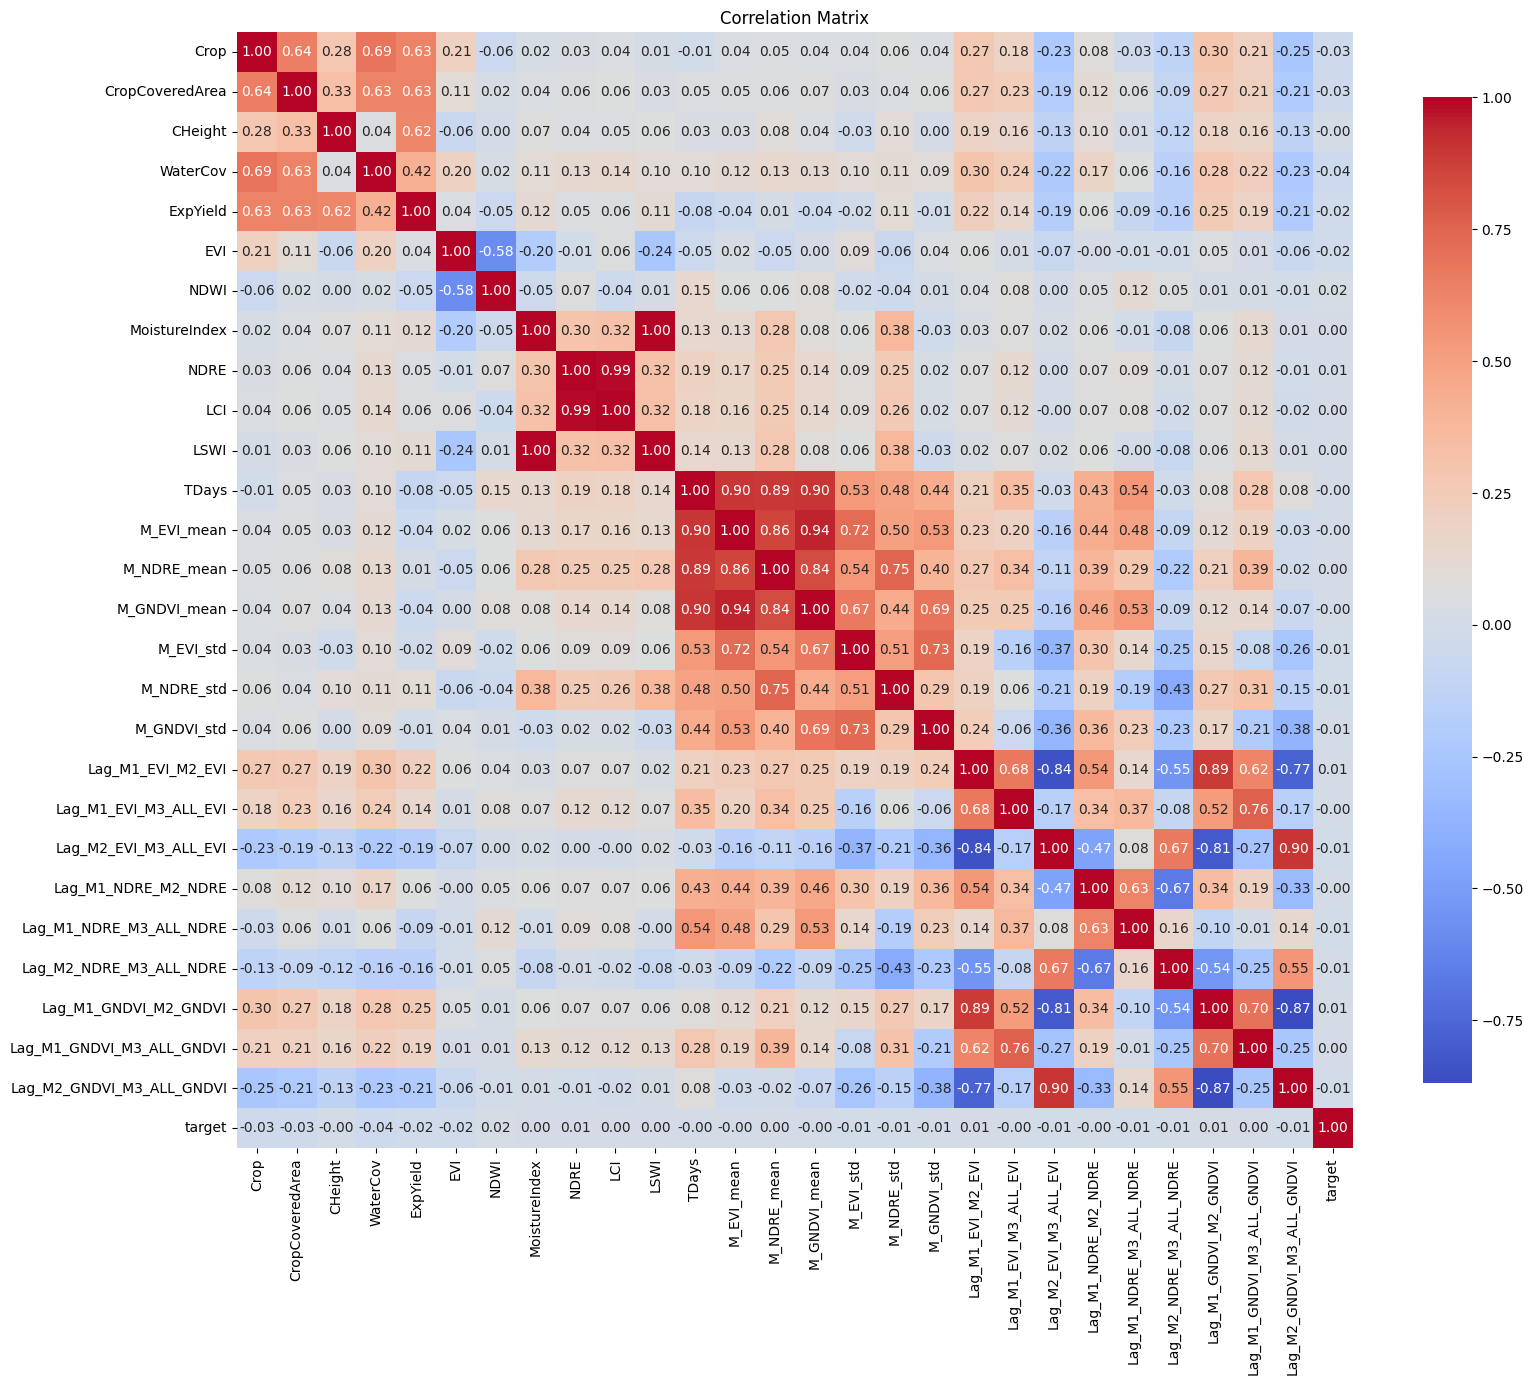

In [1183]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame
correlation_matrix = train_df.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

### LGBM Model Building

In [1186]:
# Separate features and target variable in the train set
train_df = train_df[train_df.TDays <= 18*30]
X = train_df.drop(columns=['target'])
y = train_df['target'].astype(int)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, 
                                                      stratify=y, random_state=42)
X_train.shape, X_valid.shape

((6167, 27), (1542, 27))

In [1188]:
best_params = {
 'learning_rate': 0.1,
 'num_leaves': 32,
 'max_depth': 16,}

In [1190]:
# Define LGBM model
lgbm_base = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    **best_params,
    random_state=42,)
lgbm_base.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5992
[LightGBM] [Info] Number of data points in the train set: 6167, number of used features: 27
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced', max_depth=16, num_leaves=32,
               objective='multiclass', random_state=42)

In [1192]:
# Predict on the validation set
y_pred = lgbm_base.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.83      0.87      0.85      1272
    Diseased       0.11      0.11      0.11        93
       Pests       0.06      0.04      0.05        95
    Stressed       0.08      0.05      0.06        82

    accuracy                           0.73      1542
   macro avg       0.27      0.27      0.27      1542
weighted avg       0.70      0.73      0.71      1542


Weighted F1 Score: 0.7123293552564798


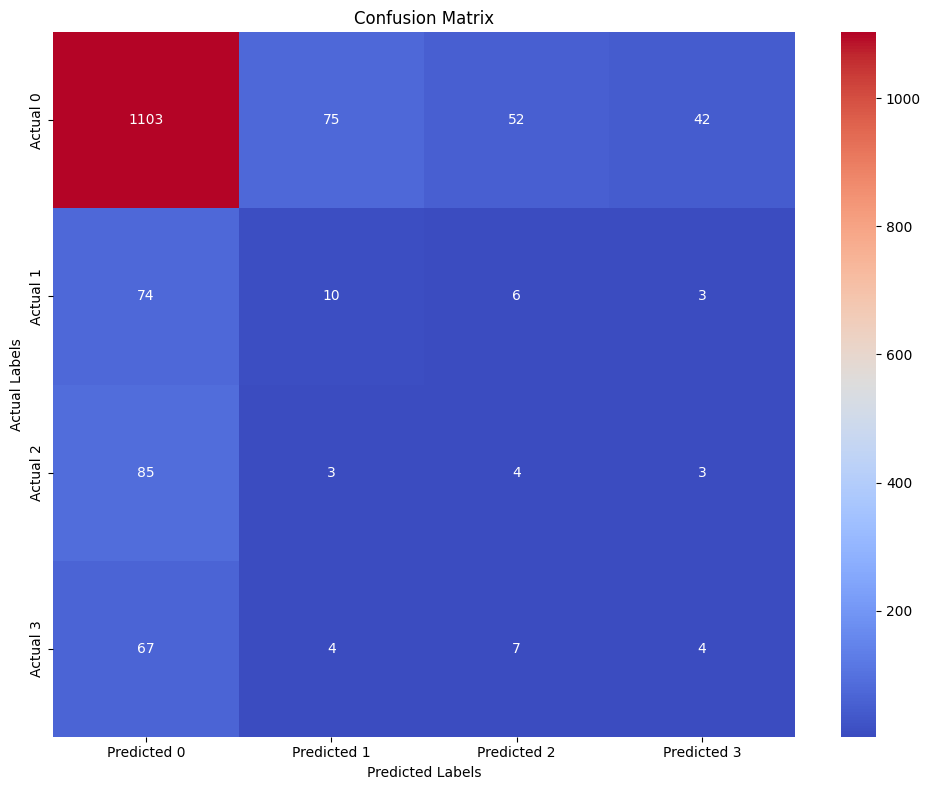

In [1194]:
plot_confusion_matrix(y_valid, y_pred)

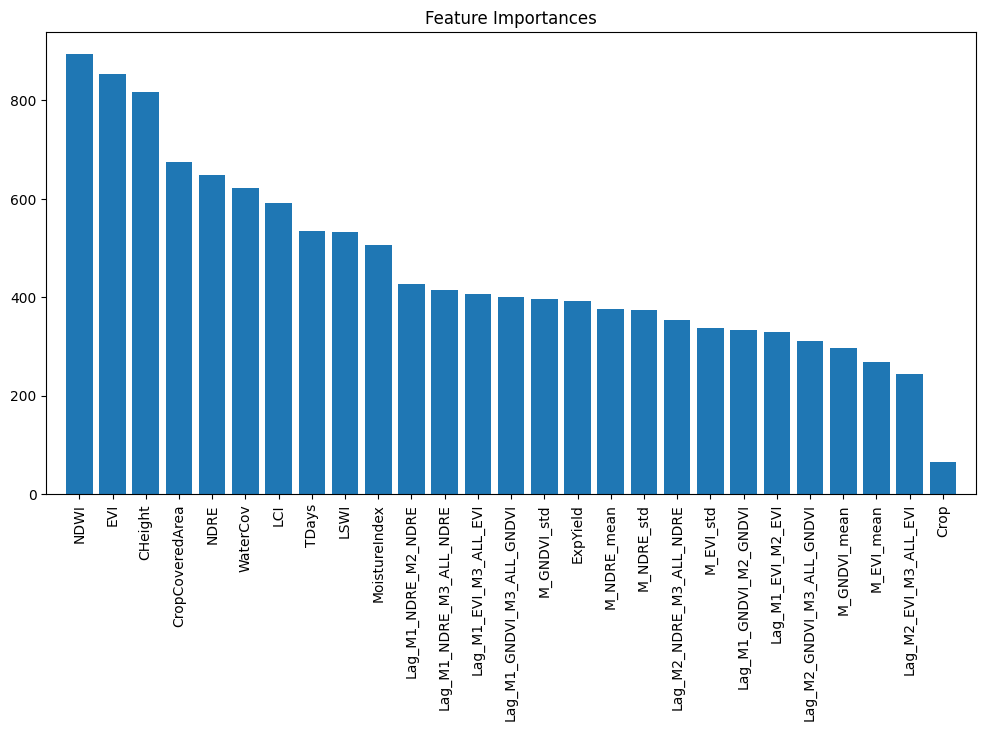

In [1196]:
import matplotlib.pyplot as plt

# Feature Importance Plot
importances = lgbm_base.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### Model testing

#### collect test data

In [1200]:
# Define file paths
qtr_tfile = 'data/processed/input_data/test_qtr_indx.csv'
indices_tfile = 'data/processed/test_s2_indices_v1.csv'

# Prepare the training data

test_df = prepare_indeces_data_stats(qtr_tfile, 
                           indices_tfile,
                           target_substrings=['M1','M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']
                            )

In [1202]:
# Fill NaN values in all columns with category-wise mean
test_df = test_df.groupby("Crop").apply(
    lambda group: group.fillna(group.mean(numeric_only=True))
).reset_index(drop=True)
test_df.drop(columns=drp_col, inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718 entries, 0 to 2717
Data columns (total 66 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Crop              2718 non-null   int64  
 1   CropCoveredArea   2718 non-null   int64  
 2   CHeight           2718 non-null   int64  
 3   WaterCov          2718 non-null   int64  
 4   ExpYield          2718 non-null   int64  
 5   EVI               2718 non-null   float64
 6   NDWI              2718 non-null   float64
 7   MoistureIndex     2718 non-null   float64
 8   NDRE              2718 non-null   float64
 9   LCI               2718 non-null   float64
 10  LSWI              2718 non-null   float64
 11  M1_EVI            2718 non-null   float64
 12  M1_MoistureIndex  2718 non-null   float64
 13  M1_NDRE           2718 non-null   float64
 14  M1_LSWI           2718 non-null   float64
 15  M1_LCI            2718 non-null   float64
 16  M1_GNDVI          2718 non-null   float64


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_49164/2030187305.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby("Crop").apply(


In [1122]:
test_df.head()

,Crop,CropCoveredArea,CHeight,WaterCov,ExpYield,NDVI,EVI,NDWI,GNDVI,SAVI,...,M_GNDVI_std,Interaction_M1_EVI_x_M2_EVI,Interaction_M1_EVI_x_M3_ALL_EVI,Interaction_M2_EVI_x_M3_ALL_EVI,Interaction_M1_NDRE_x_M2_NDRE,Interaction_M1_NDRE_x_M3_ALL_NDRE,Interaction_M2_NDRE_x_M3_ALL_NDRE,Interaction_M1_GNDVI_x_M2_GNDVI,Interaction_M1_GNDVI_x_M3_ALL_GNDVI,Interaction_M2_GNDVI_x_M3_ALL_GNDVI
0,0,78,42,39,12,0.065803,0.087392,-0.093984,0.093984,0.049979,...,0.119938,0.085174,0.020488,0.013795,0.000696,0.000095,0.000050,0.052224,0.009774,0.008009
1,0,61,40,38,8,0.138392,0.186357,-0.159279,0.159279,0.104145,...,0.066464,0.017727,0.011666,0.009572,0.000143,0.000055,0.000159,0.006061,0.004160,0.003583
2,0,71,40,22,11,0.056475,0.071787,-0.085133,0.085133,0.042324,...,0.059802,0.000000,0.002371,0.000000,0.000000,0.000056,0.000000,0.000000,0.002644,0.000000
3,0,61,50,31,10,0.105670,0.117750,-0.137453,0.137453,0.078963,...,0.061994,0.027037,0.008688,0.010574,0.000294,0.000049,0.000147,0.011259,0.005085,0.003560
4,0,59,43,32,8,0.109596,0.138619,-0.137009,0.137009,0.084057,...,0.105207,0.027788,0.002150,0.007512,0.000525,0.000037,0.000037,0.012577,0.001263,0.007781


### Prediction 

In [1124]:
# Predict submission
lg_predictions = lgbm_base.predict(test_df)
lg_predictions

array([0, 0, 0, ..., 0, 3, 0])

In [1126]:
pd.DataFrame(lg_predictions).value_counts()

0
0    2477
2      95
1      83
3      63
Name: count, dtype: int64

In [1128]:
t_data = pd.read_csv(indices_tfile, index_col=0)
t_data['Target'] = lg_predictions
t_data['Target'] = t_data['Target'].astype(int).map(idx_to_category_mapper)
subm_df = t_data[['FarmID', 'Target']]

In [1130]:
subm_df.groupby('Target').count()

,FarmID
Target,
Diseased,83
Healthy,2477
Pests,95
Stressed,63


In [962]:
subm_df.to_csv('data/sub_files/submission_27-12.csv', index=0)

In [759]:
pd.read_csv('data/sub_files/submission_27-04.csv').groupby('Target').count()

,FarmID
Target,
Diseased,113
Healthy,2363
Pests,138
Stressed,104


## Test data exploration 

In [1207]:
indices_tfile = 'data/processed/test_s2_indices_v1.csv'
test_data = pd.read_csv(indices_tfile, index_col=0)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2718 entries, 0 to 2717
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FarmID           2718 non-null   int64  
 1   Crop             2718 non-null   object 
 2   State            2718 non-null   object 
 3   District         2718 non-null   object 
 4   Sub-District     2718 non-null   object 
 5   SDate            2718 non-null   object 
 6   HDate            2718 non-null   object 
 7   CropCoveredArea  2718 non-null   int64  
 8   CHeight          2718 non-null   int64  
 9   CNext            2718 non-null   object 
 10  CLast            2718 non-null   object 
 11  CTransp          2718 non-null   object 
 12  IrriType         2718 non-null   object 
 13  IrriSource       2718 non-null   object 
 14  IrriCount        2718 non-null   int64  
 15  WaterCov         2718 non-null   int64  
 16  ExpYield         2718 non-null   int64  
 17  Season           27

In [1238]:
test_data['SDate'] = pd.to_datetime(test_data['SDate'])
test_data['HDate'] = pd.to_datetime(test_data['HDate'])
test_data['TDays'] = (test_data['HDate'] - test_data['SDate']).dt.days
# Train data 
data['SDate'] = pd.to_datetime(data['SDate'])
data['HDate'] = pd.to_datetime(data['HDate'])
data['TDays'] = (data['HDate'] - data['SDate']).dt.days

In [1246]:
test_data[test_data.TDays >= 18*30].describe().round(2)

,FarmID,SDate,HDate,CropCoveredArea,CHeight,IrriCount,WaterCov,ExpYield,NDVI,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,LCI,LSWI,TDays
count,49.00,49,49,49.00,49.00,49.00,49.00,49.0,49.00,49.00,49.00,49.00,49.00,49.00,49.00,49.00,49.00,49.00,49.00
mean,1308906.69,2023-03-01 16:09:47.755101952,2024-10-17 02:26:56.326530560,75.04,118.27,3.88,60.29,15.8,0.14,0.19,-0.17,0.17,0.12,0.12,0.24,0.02,0.03,0.22,595.43
min,606460.00,2023-01-06 00:00:00,2024-09-01 00:00:00,42.00,50.00,2.00,40.00,5.0,-0.04,-0.34,-0.43,-0.01,-0.04,-0.05,-0.02,-0.03,-0.03,-0.06,540.00
25%,1318750.00,2023-02-11 00:00:00,2024-09-16 00:00:00,65.00,74.00,3.00,45.00,10.0,0.04,0.10,-0.27,0.06,0.03,0.03,0.10,0.02,0.02,0.08,556.00
50%,1323571.00,2023-03-08 00:00:00,2024-10-19 00:00:00,76.00,90.00,4.00,54.00,17.0,0.14,0.22,-0.16,0.16,0.12,0.11,0.18,0.03,0.03,0.16,601.00
75%,1328476.00,2023-03-12 00:00:00,2024-11-05 00:00:00,90.00,189.00,5.00,60.00,21.0,0.25,0.31,-0.06,0.27,0.21,0.20,0.27,0.03,0.04,0.25,631.00
max,1331853.00,2023-06-11 00:00:00,2024-12-05 00:00:00,96.00,247.00,6.00,100.00,25.0,0.42,0.65,0.01,0.43,0.37,0.36,0.62,0.06,0.06,0.63,691.00
std,102634.38,NaN,NaN,15.33,64.63,1.24,19.56,6.1,0.13,0.20,0.12,0.12,0.11,0.10,0.19,0.02,0.02,0.20,42.68


In [1244]:
data[data.TDays >= 18*30].describe().round(2)

,FarmID,SDate,HDate,CropCoveredArea,CHeight,IrriCount,WaterCov,ExpYield,NDVI,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,LCI,LSWI,TDays
count,150.00,150,150,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00
mean,1295187.07,2023-03-05 13:55:12,2024-10-17 06:24:00,77.33,95.38,3.51,60.49,15.01,0.13,0.22,-0.15,0.15,0.11,0.11,0.19,0.03,0.03,0.17,591.69
min,166178.00,2023-01-07 00:00:00,2024-07-03 00:00:00,40.00,33.00,1.00,21.00,5.00,-0.10,-0.18,-0.40,-0.03,-0.07,-0.06,-0.02,-0.01,-0.01,-0.07,540.00
25%,1320201.75,2023-02-10 00:00:00,2024-09-04 06:00:00,66.00,62.00,2.00,44.25,10.00,0.04,0.12,-0.23,0.06,0.04,0.04,0.12,0.02,0.02,0.09,569.00
50%,1327804.00,2023-03-03 12:00:00,2024-11-03 00:00:00,81.00,78.00,3.00,53.00,15.50,0.10,0.21,-0.13,0.13,0.10,0.09,0.18,0.03,0.03,0.15,574.00
75%,1329847.50,2023-04-11 00:00:00,2024-12-02 00:00:00,90.75,110.75,5.00,84.00,20.00,0.21,0.30,-0.06,0.23,0.18,0.17,0.24,0.04,0.04,0.21,622.75
max,1332002.00,2023-06-12 00:00:00,2024-12-05 00:00:00,99.00,249.00,6.00,100.00,25.00,0.40,0.93,0.03,0.40,0.35,0.34,0.57,0.19,0.19,0.58,693.00
std,167173.42,NaN,NaN,16.09,50.81,1.42,22.40,5.80,0.11,0.15,0.10,0.10,0.09,0.08,0.11,0.02,0.02,0.12,40.17
